# Joining Emcee with Pymc3
Author: [Shaun Read](https://github.com/philastrophist/)

[Emcee](http://dan.iel.fm/emcee/current/) is a python implementation of [Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml). It succeeds where other samplers fail in sampling hard posteriors and uses an ensemble of walkers (inter-communicating chains). Emcee is very popular and [has been tagged onto Pymc in the past](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml), here Pymc3 supports Emcee as an additional step function imported from `pymc3.externals`.

## An example: Fitting a straight line
We'll use the example model from [Pythonic Perambulations](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) to see how build a simple model in pure python for emcee and then in the pymc3 model specification syntax for use with emcee (or indeed any other sampler).  


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
true_intercept, true_gradient, true_sigma = 25, 0.5, 10
xdata = 100 * np.random.random(20)
ydata = true_intercept + true_gradient * xdata

# add scatter to points
xdata = np.random.normal(xdata, true_sigma)
ydata = np.random.normal(ydata, true_sigma)

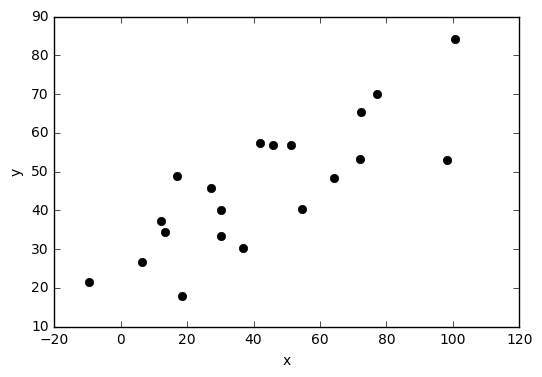

In [2]:
plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y');

## Fitting a straight line in emcee

In [3]:
def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

In [4]:
import scipy.optimize as op
nll = lambda p, *args: -log_posterior(p, *args)
result = op.minimize(nll, [0., 20., 5.], args=(xdata, ydata))

In [5]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [6]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xdata, ydata))
sampler.run_mcmc(pos, 1000);

Select a burntin selection of 1950 samples

In [7]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

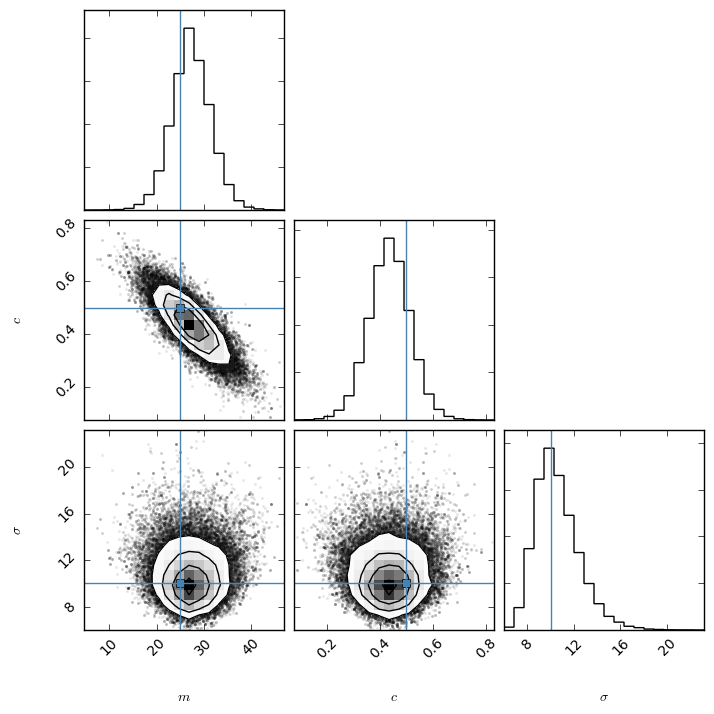

In [8]:
import corner
corner.corner(samples, labels=["$m$", "$c$", "$\sigma$"], truths=[true_intercept, true_gradient, true_sigma]);

## The same with Pymc3+Emcee!
With no changes to the api, we can use Emcee and pymc3's clever initialiser, ADVI. Therefore, we can avoid all the tedious model specifications and walker randomisation that we have to do when just using Emcee!

In [9]:
import pymc3 as pm

In [10]:
from pymc3.external.emcee_samplers import EmceeEnsemble
# new import from externals (you need to install emcee separately)

In [11]:
import theano.tensor as tt

model_x = np.linspace(xdata.min(), xdata.max())  # here only so we can have a pretty plot without much fuss
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10)
    intercept = pm.Normal('intercept', mu=0, sd=10)
    gradient = pm.Normal('gradient', mu=0, sd=10)
    prior = pm.Potential('prior', ((1 + intercept**2)**(-3./2)) / sigma)  # optional prior
    pm.Deterministic('model_line', intercept + (model_x * gradient))  # just for plotting
    line = intercept + (xdata * gradient)
    like = pm.Normal('like', mu=line, sd=sigma, observed=ydata)

In [12]:
with model:
    trace = pm.sample(1000, step=EmceeEnsemble(), nparticles=100)  # you don't have to specify nparticles. Default = (ndim + 1) * 2

Initializing using advi...
Average ELBO = -86.04: 100%|██████████████████████████████| 200000/200000 [00:11<00:00, 17739.93it/s]
Finished [100%]: Average ELBO = -86.032
100%|███████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.16it/s]


So much quicker with the theano backend and no need for initialisation with scipy.optimize!

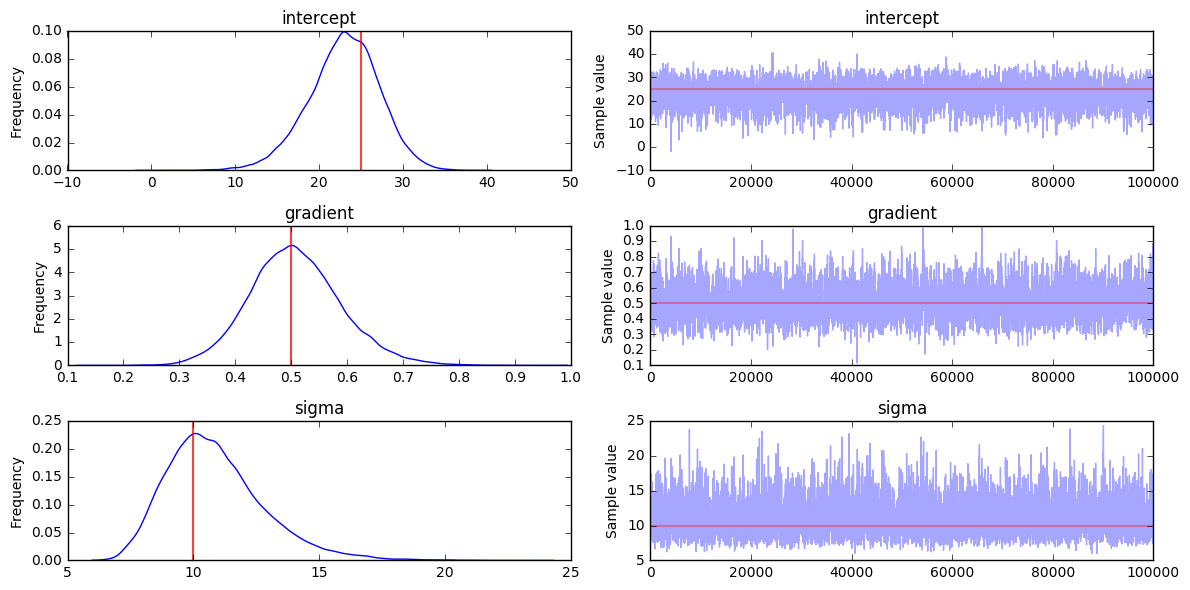

In [13]:
pm.traceplot(trace, ['intercept', 'gradient', 'sigma'], lines={'gradient': true_gradient, 'intercept': true_intercept, 
                                                            'sigma': true_sigma}, combined=True);

In [14]:
samples = np.stack([trace['gradient'], trace['intercept'], trace['sigma']]).T

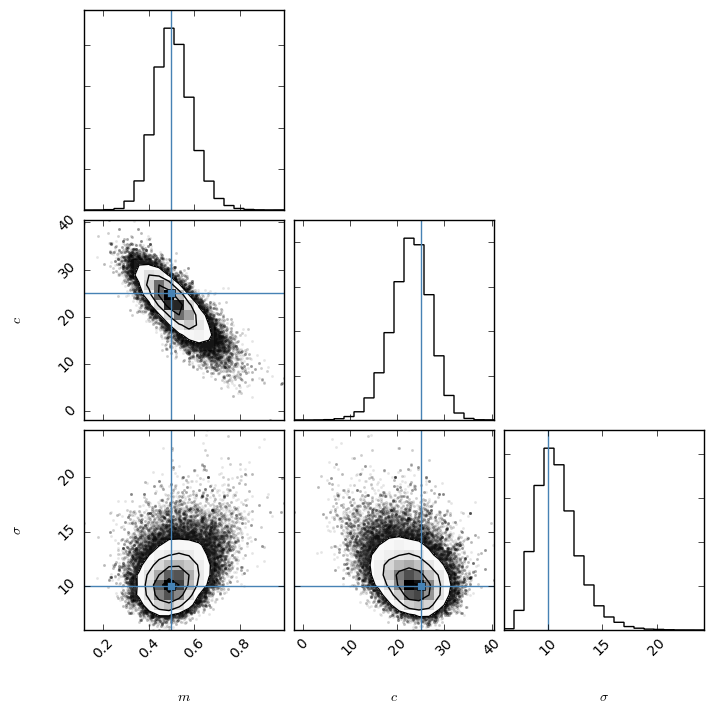

In [15]:
corner.corner(samples, labels=["$m$", "$c$", "$\sigma$"], truths=[true_gradient, true_intercept, true_sigma]);

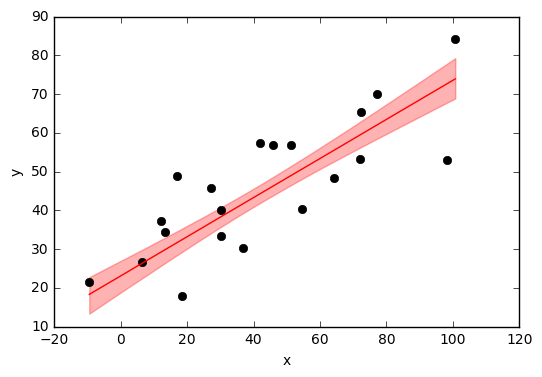

In [16]:
plt.plot(xdata, ydata, 'ok')
line = np.percentile(trace['model_line'], [16, 50, 84], axis=0)
plt.plot(model_x, line[1], 'r-')
plt.fill_between(model_x, line[0], line[2], color='r', alpha=0.3)
plt.xlabel('x')
plt.ylabel('y');

Clearly, the results identical (you would hope)

## Additional points, tips and uses
The EmceeEnsemble step function in pymc3 uses the same initialisation and start specifications as normal pymc3 so we can make se of them. The following are valid inputs:

`pm.sample(1000, step=EmceeEnsemble(), init='random')` uses random draws from the base distributions as a starting point for the walkers.
`pm.sample(1000, step=EmceeEnsemble(), init='advi')` uses the very cool advi initialisation (default).

You can specify your own starting points with standard start dictionary:
`pm.sample(1000, step=EmceeEnsemble(), start={'var1': [v_1, v_2, v_3], 'var2':...})`
`pm.sample(1000, step=EmceeEnsemble(), start={'var1': array, 'var2':...})`, where array shape is `(nparticles, ) + variable_shape`

To start initialisation somewhere you can use `init_start`:
`pm.sample(1000, step=EmceeEnsemble(), init_start={'var1': array, 'var2':...})`, where array shape is the shape of the variable

`pm.sample(1000, step=EmceeEnsemble(), init=None)` is a valid call but it is not advised to be used with emcee since this will use a starting point of duplicated model test points and emcee needs its walkers to be spread out a bit!

This a restrictive type of step function specification, and only works for particle steps like emcee which do incrementation for all particles at once. 